# 1 - Introduction

Nama : Muhamad Fandhi 

Batch : HCK - 003

Dataset : Pepsi and CocaCola Dataset

Dataset URL : https://www.kaggle.com/datasets/die9origephit/pepsi-and-cocacola-images

Objective : Creating a computer vision model for detecting Pepsi and CocaCola products.

Deployment URL :
``
https://huggingface.co/spaces/mfandhi/cola-or-pepsi
``

# 2 - Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(69)
from sklearn.metrics import classification_report,roc_auc_score

from pathlib import Path
!pip install -q jmd_imagescraper
from jmd_imagescraper.core import *
import glob
import os

In [2]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
kaggle.json
total 4
-rw------- 1 root root 63 Feb  8 16:33 kaggle.json
{"username":"mfandhi","key":"e740dfd14b48ac7b491b3ce347c7a4f0"}

# 3 - Data Loading

Here, we will download the data from Kaggle. Since the download data will be archived in .zip we will also extract the file. Then we can load the images for each class (cocacola and pepsi). We will show the loaded files in the next section, Exploratory Data Analysis Section.

In [3]:
!kaggle datasets download -d die9origephit/pepsi-and-cocacola-images
!unzip -q /content/pepsi-and-cocacola-images.zip

coke_files = glob.glob('/content/train/cocacola/*')
pepsi_files = glob.glob('/content/train/pepsi/*')

pepsi-and-cocacola-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/cocacola/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# 4 - Exploratory Data Analysis

Here we will explore our data which are images of coca-cola and pepsi products. First we want to know the images size for our data.

In [4]:
print(plt.imread(coke_files[1]).shape)
print(plt.imread(pepsi_files[1]).shape)

(270, 230, 3)
(270, 230, 3)


Here, we can see that the size of our images are 270 in height and 230 in width. We can also see that these images have 3 channel for RGB channel.

## Coca-Cola

Next, we want to see the coca cola images.

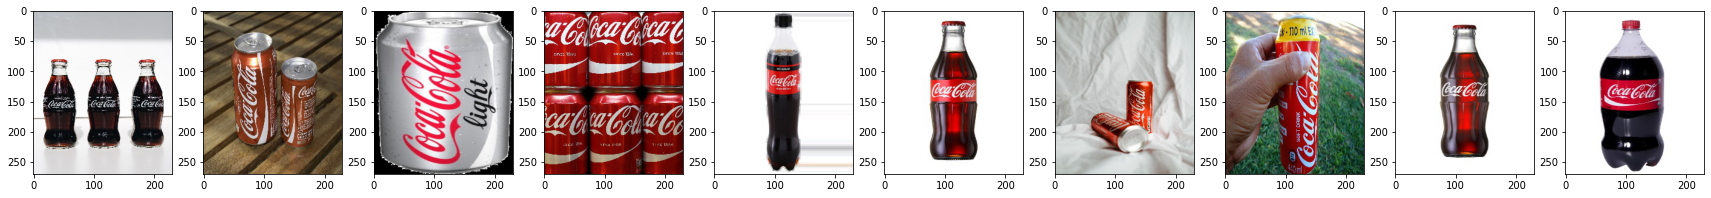

In [5]:
fig,ax = plt.subplots(ncols=10,figsize=(30,3))
for i in range(10):
  coke = plt.imread(coke_files[i])
  ax[i].imshow(coke)

Here we have 10 samples of our coca-cola products images. These images are quite diverese. From these samples, we have coca-cola products in glass bottle, canned bottle, and also plastic bottle. We can also see that there are variety of products in our coca cola images. We have the red can for standard coca cola and the silver can for coca cola light.

## Pepsi

Next, we want to see the pepsi images.

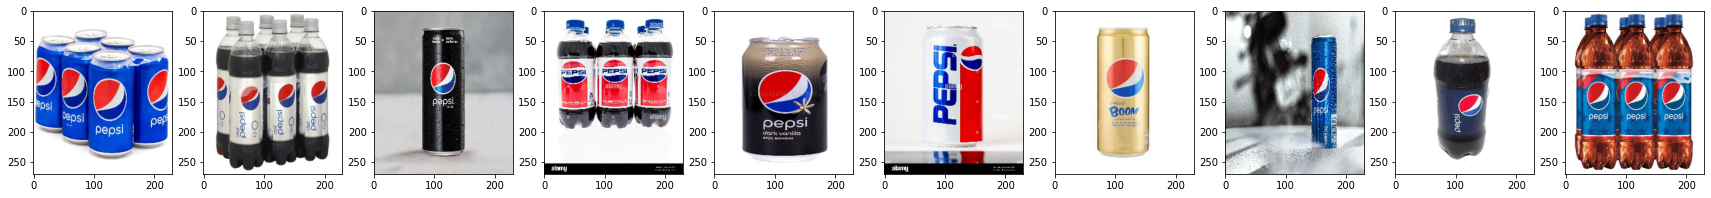

In [6]:
fig,ax = plt.subplots(ncols=10,figsize=(30,3))
for i in range(10):
  pepsi = plt.imread(pepsi_files[i])
  ax[i].imshow(pepsi)

Here we have 10 samples of our pepsi products images. These images are also quite diverese. From these samples, we have pepsi products in canned bottle, and plastic bottle. There are also variety of products packaging, we have blue, black, gold, and also silver packaging for the pepsi products images.

We can also see that the 2 class images (coca-cola and pepsi) have some image that the objects reach the edges of the image. This is a sign for us to use padding when we build the model or we can just have the base model without padding and see if it would be better with padding.

# 5 - Data Preprocessing

In this section we will preprocess our data before we go into the modelling section. First we want to load the datasets for modelling needs (train, validation, and test). We are loading the same data as the EDA section but with different method, because with this method (image_dataset_from_directory), while we load the data, we will also resize the loaded image to 150x150 and set the batch sizes (train and val = 32, test = 60).

In [7]:
# defining the image size for resizing our data
image_size = (150, 150)
# defining the batch size for our data
batch_size = 32


# loading training dataset
# splitting the train dataset into train and val with val split 0.2
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="training",
    seed=69,
    image_size=image_size,
    batch_size=batch_size,
)

# load val dataset 0.2 from train folder
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="validation",
    seed=69,
    image_size=image_size,
    batch_size=batch_size,
)

# load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/test",
    seed=69,
    image_size=image_size,
    batch_size=60,
    shuffle=False
)

Found 340 files belonging to 2 classes.
Using 272 files for training.
Found 340 files belonging to 2 classes.
Using 68 files for validation.
Found 60 files belonging to 2 classes.


After we load the data for train, validation, and test, we will show some of our train image and see if the label match the images.

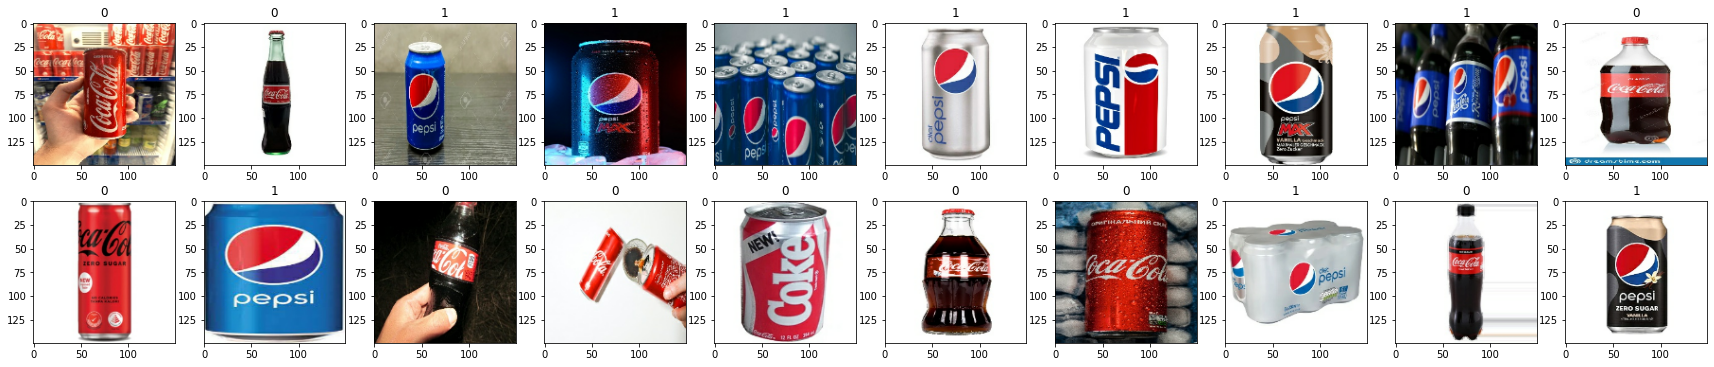

In [8]:
plt.figure(figsize=(30, 6))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis()

Here, we can see 20 sample of train images and the images are matched with the label.

## Data Augmentation

In this section, we will augment our data so that the model artificially introduced sample diversity by applying random yet realistic transformations to the training images. We will set random flip, random rotation, and random zoom to our images. This helps expose the model to different aspects of the training data while reducing overfitting.

In [9]:
# defining the data augmentation

data_aug = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.5,0.5)
])

Now we want to visualize what the augmented samples look like, by applying data_aug repeatedly to the first image in the dataset:

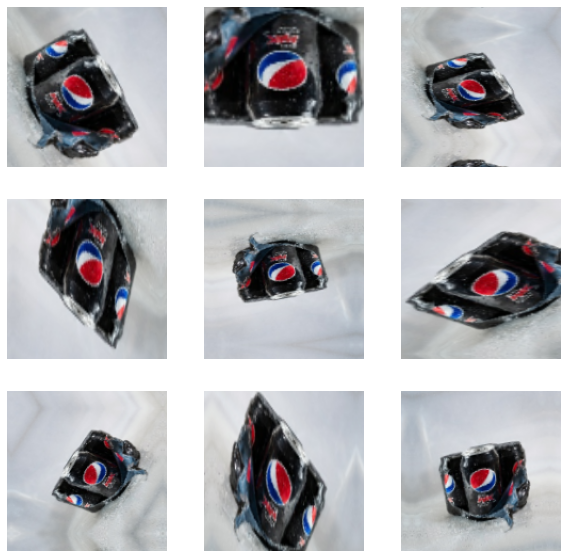

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis('off')

Next, we want to apply data augmentation to our training dataset, and we want to prefetch the dataset in GPU memory to help maximize GPU utilization.

In [11]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_aug(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Notice we didn't scale the images pixels in this section. We will rescale the images in the model creation section.

# 6 - Model Creation

In this section we will train our model using Convolutional Neural Network. In this model we will start by rescalling the images pixel data (dividing by 255),set 3 layers of Conv2D with activation function 'relu', adding maxpooling after each Conv2D layers, and then flatten with 0.5 dropout, and the last adding dense layer with 64 neurons. Since the labels are only 2 (coca-cola and pepsi) we will use sigmoid activation function in our output layer. 

In [12]:
# Define Model's Architecture

input_lyr = layers.Input(shape=(150, 150, 3))
x = layers.Rescaling(1.0 / 255)(input_lyr)      # scaling the data
x = layers.Conv2D(16, (3,3),activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=input_lyr,outputs=output)

After defining the model's architecture we can see the summary of our model.

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                         

Here, we can see that we have 1.2 M total params and all of them are trainable. Next, we will define the training configuration by setting the optimizer, loss, and metric. For this model we use the optimizer RMSprop, binary cross entropy for the loss, and accuracy for the metric.

In [14]:
# Define Training Configuration (Optimizer, Loss, Metrics)

model.compile(
    # Optimizer
    optimizer=tf.keras.optimizers.RMSprop(),
    
    # Loss function to minimize
    loss=tf.keras.losses.BinaryCrossentropy(),
    
    # List of metrics to monitor
    metrics=['accuracy'],
)

We will also set early stopping for this model by monitoring val_loss with patience 3 epochs.

In [15]:
# setting callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

After defining the models completely, we will train our model using the train and val data. Here, we are using 50 epochs but we are also using callbacks so this model might not reach 50 epochs.


In [16]:
# training model
history = model.fit(train_ds,epochs=50,validation_data=val_ds,callbacks=[callback])

Epoch 1/50
9/9 [==============================] - 9s 151ms/step - loss: 1.0159 - accuracy: 0.6176 - val_loss: 0.6359 - val_accuracy: 0.6029
Epoch 2/50
9/9 [==============================] - 1s 109ms/step - loss: 0.4930 - accuracy: 0.7831 - val_loss: 1.0511 - val_accuracy: 0.4853
Epoch 3/50
9/9 [==============================] - 1s 109ms/step - loss: 0.4109 - accuracy: 0.8382 - val_loss: 0.3510 - val_accuracy: 0.8088
Epoch 4/50
9/9 [==============================] - 2s 149ms/step - loss: 0.2135 - accuracy: 0.9191 - val_loss: 0.1576 - val_accuracy: 0.9706
Epoch 5/50
9/9 [==============================] - 1s 109ms/step - loss: 0.3099 - accuracy: 0.8750 - val_loss: 0.2016 - val_accuracy: 0.9559
Epoch 6/50
9/9 [==============================] - 1s 108ms/step - loss: 0.1491 - accuracy: 0.9338 - val_loss: 0.1751 - val_accuracy: 0.8824
Epoch 7/50
9/9 [==============================] - 1s 108ms/step - loss: 0.1474 - accuracy: 0.9559 - val_loss: 0.1193 - val_accuracy: 0.9706
Epoch 8/50
9/9 [====

Here, we can see that the model stopped training at 10 epochs because it's val loss didn't go lower anymore after 3 epochs. 

## Model Evaluation

### Training and Validation 

After we completed the training, we can plot the results and evaluate the model.

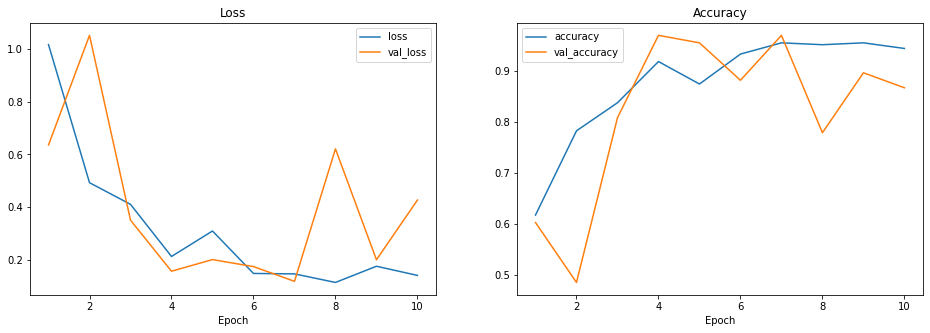

In [17]:
# plotting model results

epoch=10

# plotting loss on train and val
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# plotting accuracy on train and val
ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')


plt.show()

Here, we can see the model has a big gradient problem which is exploding gradient. Because the spike of loss and accuracy is quite big. This might happen because our model are too simple or the parameters that we use are not right.


### Test Dataset

We will use the model we created to predict on the test dataset. But first we need to extract the true label of test dataset to be able to calculate the classifiaction report.

In [18]:
# Iterate over the elements in the test dataset
for image, label in test_ds:
    # Extract the true labels for the images
    y_true = label

In [19]:
y_prob_model = model.predict(test_ds)
y_pred_model = np.round(y_prob_model)
print(classification_report(y_true,y_pred_model))
print('AUC:',roc_auc_score(y_true,y_pred_model))

1/1 [==============================] - 0s 347ms/step
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.77      1.00      0.87        30

    accuracy                           0.85        60
   macro avg       0.88      0.85      0.85        60
weighted avg       0.88      0.85      0.85        60

AUC: 0.85


On the test set we have 0.85 accuracy and 0.85 AUC score. These scores are quite high, but as we can see from the graphs before, the model is unstable. So we need to improve this model.

# 7 - Model Improvement

In this section, we will improve our model by adding one more Conv2D layer and two dense layer (one after dropout and one before output layer). We'll also add padding to each Conv2D layers and use kernel initializer glorot normal for all the layers.

In [20]:
# Define Improved Model's Architecture

input_lyr = layers.Input(shape=(150, 150, 3))
x = layers.Rescaling(1.0 / 255)(input_lyr)      # scaling the data
x = layers.Conv2D(16, (3,3),activation='relu',padding="same",kernel_initializer='glorot_normal')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3,3), activation='relu',padding="same",kernel_initializer='glorot_normal')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (3,3), activation='relu',padding="same",kernel_initializer='glorot_normal')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(128, (3,3), activation='relu',padding="same",kernel_initializer='glorot_normal')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu',kernel_initializer='glorot_normal')(x)
x = layers.Dense(64, activation='relu',kernel_initializer='glorot_normal')(x)
x = layers.Dense(32, activation='relu',kernel_initializer='glorot_normal')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model1 = tf.keras.models.Model(inputs=input_lyr,outputs=output)

After defining the model's architecture we can see the summary of our model.

In [21]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                       

Here, we can see that we have 1.4 M total params and all of them are trainable. The total params are slightly more than the first model. Next, we will define the training configuration by setting the optimizer, loss, and metric. For the improved model we use the optimizer Adam(), binary cross entropy for the loss, and accuracy for the metric. The difference with the first model is at the optimizer that we use.

In [22]:
# Define Training Configuration (Optimizer, Loss, Metrics)

model1.compile(
    # Optimizer
    optimizer=tf.keras.optimizers.Adam(),
    
    # Loss function to minimize
    loss=tf.keras.losses.BinaryCrossentropy(),
    
    # List of metrics to monitor
    metrics=['accuracy'],
)

We will also set early stopping for this model by monitoring val_loss with patience 3 epochs, same as the first model.

In [23]:
# setting callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

After defining the improved models completely, we will train our improved model using the train and val data. Here, we are using 50 epochs but we are also using callbacks so this model might not reach 50 epochs.

In [24]:
# training functional model
history1 = model1.fit(train_ds,epochs=50,validation_data=val_ds,callbacks=[callback])

Epoch 1/50
9/9 [==============================] - 3s 129ms/step - loss: 0.7020 - accuracy: 0.5257 - val_loss: 0.6779 - val_accuracy: 0.5588
Epoch 2/50
9/9 [==============================] - 1s 117ms/step - loss: 0.6716 - accuracy: 0.5662 - val_loss: 0.6083 - val_accuracy: 0.6618
Epoch 3/50
9/9 [==============================] - 1s 118ms/step - loss: 0.4229 - accuracy: 0.8235 - val_loss: 0.3775 - val_accuracy: 0.8088
Epoch 4/50
9/9 [==============================] - 2s 188ms/step - loss: 0.1870 - accuracy: 0.9154 - val_loss: 0.3893 - val_accuracy: 0.8529
Epoch 5/50
9/9 [==============================] - 1s 114ms/step - loss: 0.2371 - accuracy: 0.8934 - val_loss: 0.4014 - val_accuracy: 0.8088
Epoch 6/50
9/9 [==============================] - 1s 108ms/step - loss: 0.2100 - accuracy: 0.9265 - val_loss: 0.1949 - val_accuracy: 0.9265
Epoch 7/50
9/9 [==============================] - 1s 110ms/step - loss: 0.1169 - accuracy: 0.9485 - val_loss: 0.2086 - val_accuracy: 0.9118
Epoch 8/50
9/9 [====

Here, we can see that the improved model stopped training at 14 epochs because it's val loss didn't go lower anymore after 3 epochs. The total epochs for the improved model is more than the first model.

## Improved Model Evaluation

### Training and Validation

After we completed the training, we can plot the results and evaluate the improved model.

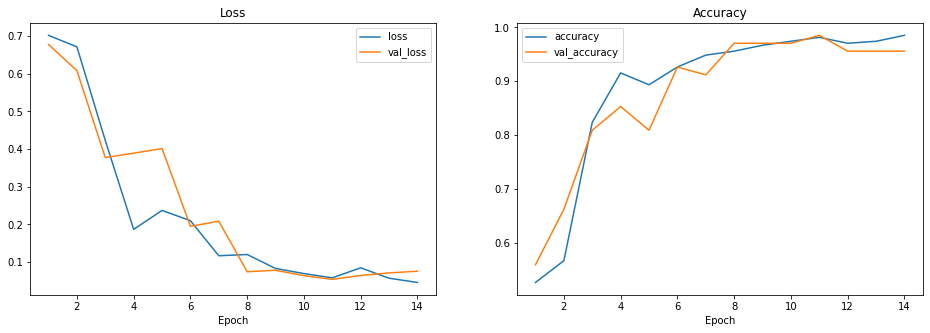

In [26]:
# plotting model results

epoch=14

# plotting loss on train and val
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# plotting accuracy on train and val
ax[1].plot(range(1,epoch+1),history1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')


plt.show()

Here, we can see the imprpoved model has a less gradient problem than the first model. The spikes are still there but not as bad as the first model. This is an improvement for this model on train and test data. This might happen because our improved model are using the right parameters and optimizer.

### Test Dataset

We will use the model we created to predict on the test dataset.

In [27]:
y_prob_model1 = model1.predict(test_ds)
y_pred_model1 = np.round(y_prob_model1)
print(classification_report(y_true,y_pred_model1))
print('AUC:',roc_auc_score(y_true,y_pred_model1))

1/1 [==============================] - 0s 376ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

AUC: 1.0


On the test set we have 1.0 accuracy and 1.0 AUC score. These scores are perfect score, and from the graphs before, the improved model is more stable than the first model.

# 8 - Conclusion

From what we have done, we can conclude that:

1. The dataset contains images of coca-cola and pepsi products with each of brands variant (light, diet, packaging, etc)

2. For this dataset, the model can't be too simple. In this case, we use 4 layers of Conv2D (with layers 16,32,64,128 neurons respectively), 3 dense layers (128,64,32 neurons respectively), use paddings and kernel initializer glorot normal and adam optimizer.

3. The improved model is best fit for this data. With accuracy score 0.98 on train and val, and for the test data 1.0. 

# 9 - Further Improvement

Achieving a perfect score in a computer vision model is a bit unreal. This might happen because the dataset we have is limited because we only have 400 images in total for train, val, and test. We can also see that the improved model, although it has a really high score, it still had little gradient problem. The **improvement that can be done** for this model is **adding more data to train and test** and **tuning the paramaters further** by changin the kernel initializer, optimizer, or adding or removing several layers to the model's architecture to achieve a more stable model.

# 10 - Model Saving

Save the improved model for inferencing.

In [28]:
model1.save('model.h5')